In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import subprocess
import glob

In [16]:
def extract_features(image_path, feature_method='sift', max_features=5000):
    """
    Extract features from an image using different methods.
    """

    # Read the image in color and convert to grayscale
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Initialize feature detector based on method
    if feature_method.lower() == 'sift':
        detector = cv2.SIFT_create(nfeatures=max_features)
    elif feature_method.lower() == 'surf':
        # Note: SURF is patented and may not be available in all OpenCV distributions
        detector = cv2.xfeatures2d.SURF_create(400)  # Adjust threshold as needed
    elif feature_method.lower() == 'orb':
        detector = cv2.ORB_create(nfeatures=max_features)
    else:
        raise ValueError(f"Unsupported feature method: {feature_method}")
    
    # Detect and compute keypoints and descriptors
    keypoints, descriptors = detector.detectAndCompute(gray, None)
    
    # Create visualization
    img_with_features = cv2.drawKeypoints(
        img, keypoints, None, 
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    
    print(f"Extracted {len(keypoints)} {feature_method.upper()} features")
    
    return keypoints, descriptors, img_with_features


In [22]:
image_path = "imagens/img7.jpeg"  # Replace with your image path

# Extract features with different methods
kp_sift, desc_sift, vis_sift = extract_features(image_path, 'sift')
# kp_surf, desc_surf, vis_surf = extract_features(image_path, 'surf')
kp_orb, desc_orb, vis_orb = extract_features(image_path, 'orb')

Extracted 954 SIFT features
Extracted 2925 ORB features


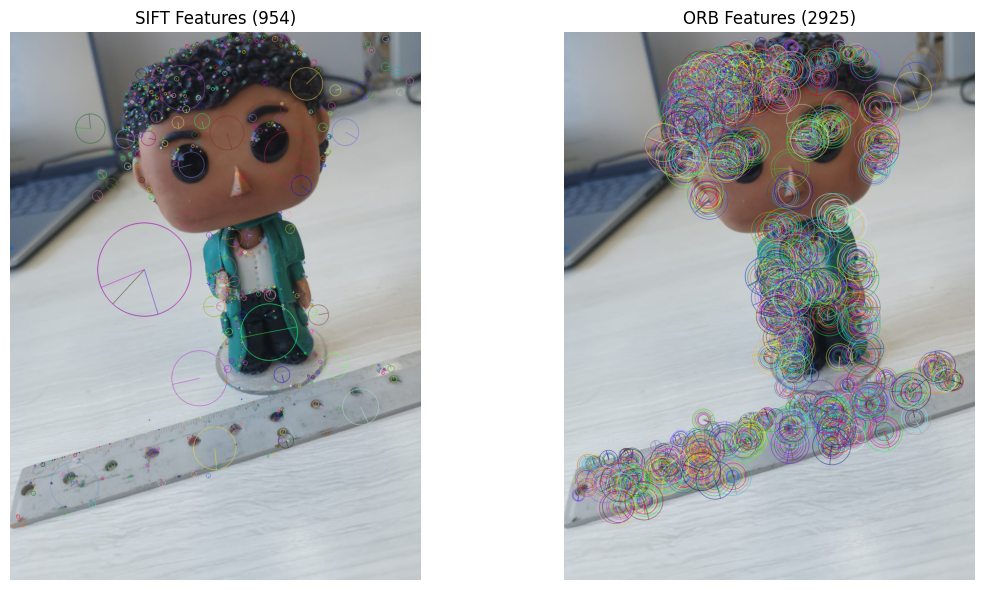

In [23]:
plt.figure(figsize=(12, 6))
    
plt.subplot(1, 2, 1)
plt.title(f'SIFT Features ({len(kp_sift)})')
plt.imshow(cv2.cvtColor(vis_sift, cv2.COLOR_BGR2RGB))
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.title(f'ORB Features ({len(kp_orb)})')
plt.imshow(cv2.cvtColor(vis_orb, cv2.COLOR_BGR2RGB))
plt.axis('off')
    
plt.tight_layout()
plt.show()

In [24]:
def match_features(descriptors1, descriptors2, method='flann', ratio_thresh=0.75):
    """
    Match features between two images using different methods.
    """

    # Convert descriptors to appropriate type if needed
    if descriptors1 is None or descriptors2 is None:
        return []
    
    if method.lower() == 'flann':
        # FLANN parameters
        if descriptors1.dtype != np.float32:
            descriptors1 = np.float32(descriptors1)
        if descriptors2.dtype != np.float32:
            descriptors2 = np.float32(descriptors2)
            
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)  # Higher values = more accurate but slower
        
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    else:  # Brute Force
        # For ORB descriptors
        if descriptors1.dtype == np.uint8:
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        else:  # For SIFT and SURF descriptors
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        
        matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for match in matches:
        if len(match) == 2:  # Sometimes fewer than 2 matches are returned
            m, n = match
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
    
    return good_matches


In [25]:
def visualize_matches(img1, kp1, img2, kp2, matches, max_display=100):
    """
    Create a visualization of feature matches between two images.
    """

    # Limit the number of matches to display
    matches_to_draw = matches[:min(max_display, len(matches))]
    
    # Create match visualization
    match_img = cv2.drawMatches(
        img1, kp1, img2, kp2, matches_to_draw, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    return match_img

In [30]:
# Load two images
img1_path = "imagens/img7.jpeg"  # Replace with your image paths
img2_path = "imagens/img12.jpeg"
    
# Extract features using SIFT (or your preferred method)
kp1, desc1, _ = extract_features(img1_path, 'sift')
kp2, desc2, _ = extract_features(img2_path, 'sift')
    
# Match features
good_matches = match_features(desc1, desc2, method='flann')
    
print(f"Found {len(good_matches)} good matches")

Extracted 954 SIFT features
Extracted 1142 SIFT features
Found 146 good matches


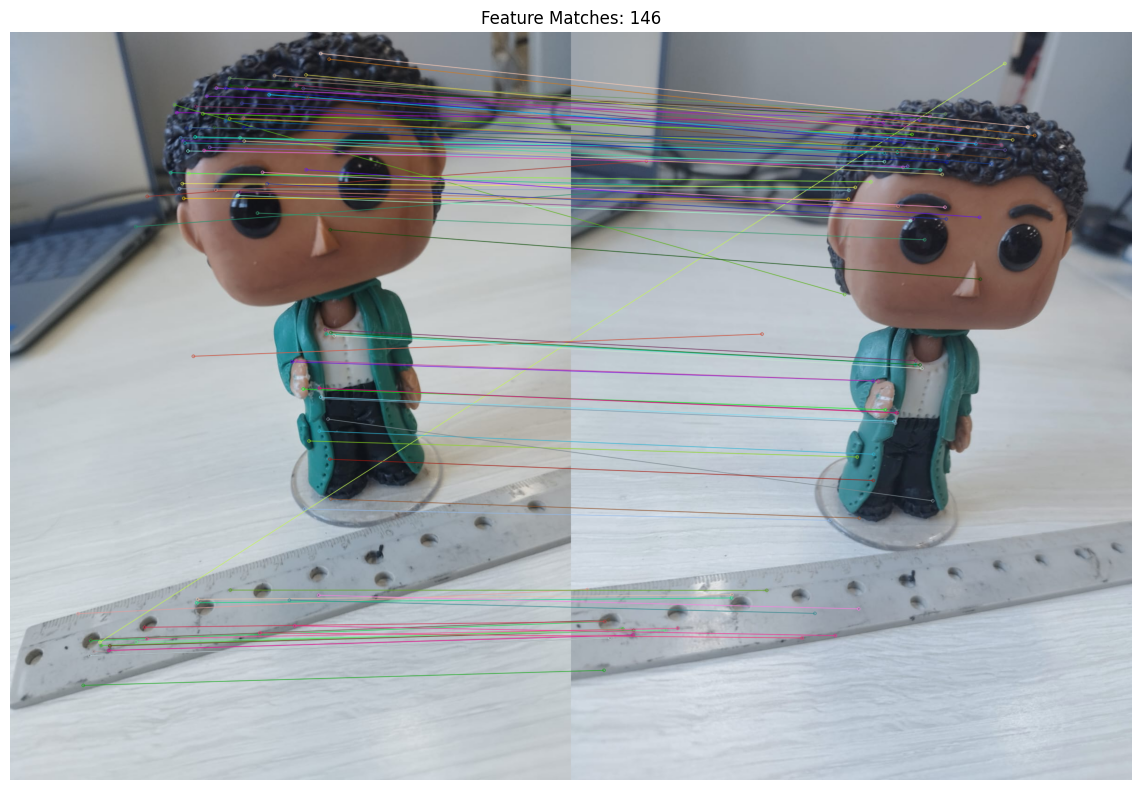

In [31]:
# Visualize matches
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
match_visualization = visualize_matches(img1, kp1, img2, kp2, good_matches)
    
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(match_visualization, cv2.COLOR_BGR2RGB))
plt.title(f"Feature Matches: {len(good_matches)}")
plt.axis('off')
plt.tight_layout()
plt.show()

In [32]:
def estimate_pose(kp1, kp2, matches, K, method=cv2.RANSAC, prob=0.999, threshold=1.0):
    """
    Estimate the relative pose between two cameras using matched features.
    """

    # Extract matched points
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    # Estimate essential matrix
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method, prob, threshold)
    
    # Recover pose from essential matrix
    _, R, t, mask = cv2.recoverPose(E, pts1, pts2, K, mask=mask)
    
    inlier_matches = [matches[i] for i in range(len(matches)) if mask[i] > 0]
    print(f"Estimated pose with {np.sum(mask)} inliers out of {len(matches)} matches")
    
    return R, t, mask, inlier_matches

In [33]:
def triangulate_points(kp1, kp2, matches, K, R1, t1, R2, t2):
    """
    Triangulate 3D points from two views.
    """

    # Extract matched points
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    # Create projection matrices
    P1 = np.dot(K, np.hstack((R1, t1)))
    P2 = np.dot(K, np.hstack((R2, t2)))
    
    # Triangulate points
    points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    
    # Convert to 3D points
    points_3d = points_4d[:3] / points_4d[3]
    
    return points_3d.T

In [34]:
def visualize_points_and_cameras(points_3d, R1, t1, R2, t2):
    """
    Visualize 3D points and camera positions.
    """

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='b', s=1)
    
    # Helper function to create camera visualization
    def plot_camera(R, t, color):
        # Camera center
        center = -R.T @ t
        ax.scatter(center[0], center[1], center[2], c=color, s=100, marker='o')
        
        # Camera axes (showing orientation)
        axes_length = 0.5  # Scale to make it visible
        for i, c in zip(range(3), ['r', 'g', 'b']):
            axis = R.T[:, i] * axes_length
            ax.quiver(center[0], center[1], center[2], 
                      axis[0], axis[1], axis[2], 
                      color=c, arrow_length_ratio=0.1)
    
    # Plot cameras
    plot_camera(R1, t1, 'red')
    plot_camera(R2, t2, 'green')
    
    ax.set_title('3D Reconstruction: Points and Cameras')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Try to make axes equal
    max_range = np.max([
        np.max(points_3d[:, 0]) - np.min(points_3d[:, 0]),
        np.max(points_3d[:, 1]) - np.min(points_3d[:, 1]),
        np.max(points_3d[:, 2]) - np.min(points_3d[:, 2])
    ])
    
    mid_x = (np.max(points_3d[:, 0]) + np.min(points_3d[:, 0])) * 0.5
    mid_y = (np.max(points_3d[:, 1]) + np.min(points_3d[:, 1])) * 0.5
    mid_z = (np.max(points_3d[:, 2]) + np.min(points_3d[:, 2])) * 0.5
    
    ax.set_xlim(mid_x - max_range * 0.5, mid_x + max_range * 0.5)
    ax.set_ylim(mid_y - max_range * 0.5, mid_y + max_range * 0.5)
    ax.set_zlim(mid_z - max_range * 0.5, mid_z + max_range * 0.5)
    
    plt.tight_layout()
    plt.show()

In [36]:

# This is a simplified example - in practice you would use images and matches
# from the previous steps
    
# Example camera intrinsic matrix (replace with your calibrated values)
K = np.array([
        [1000, 0, 320],
        [0, 1000, 240],
        [0, 0, 1]
])
    
# For first camera, we use identity rotation and zero translation
R1 = np.eye(3)
t1 = np.zeros((3, 1))
    
# Load images, extract features, and match as in previous sections
img1_path = "imagens/img7.jpeg"  # Replace with your image paths
img2_path = "imagens/img12.jpeg"
    
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
    
kp1, desc1, _ = extract_features(img1_path, 'sift')
kp2, desc2, _ = extract_features(img2_path, 'sift')
    
matches = match_features(desc1, desc2, method='flann')
    
# Estimate pose of second camera relative to first
R2, t2, mask, inliers = estimate_pose(kp1, kp2, matches, K)
    
# Triangulate points
points_3d = triangulate_points(kp1, kp2, inliers, K, R1, t1, R2, t2)

Extracted 954 SIFT features
Extracted 1142 SIFT features
Estimated pose with 64 inliers out of 144 matches


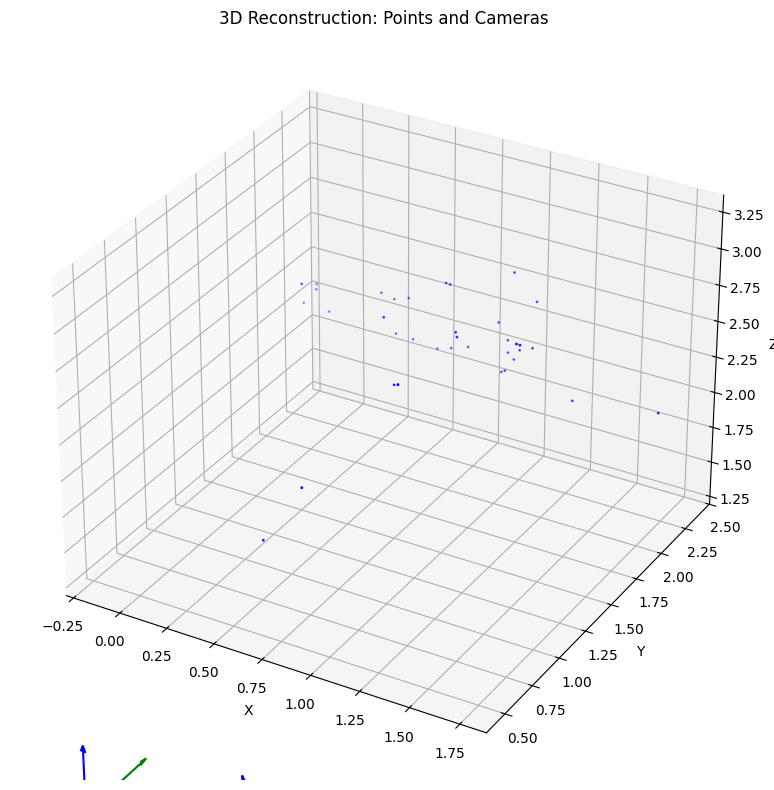

In [29]:
# Visualize the result
visualize_points_and_cameras(points_3d, R1, t1, R2, t2)

In [ ]:
def run_colmap_pipeline(image_folder, output_folder, colmap_path="colmap"):
    """
    Run the complete COLMAP pipeline from feature extraction to dense reconstruction.
    """

    # Create output directories if they don't exist
    sparse_folder = os.path.join(output_folder, "sparse")
    dense_folder = os.path.join(output_folder, "dense")
    database_path = os.path.join(output_folder, "database.db")
    
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(sparse_folder, exist_ok=True)
    os.makedirs(dense_folder, exist_ok=True)
    
    # Step 1: Feature extraction
    print("Step 1: Feature extraction")
    feature_cmd = [
        colmap_path, "feature_extractor",
        "--database_path", database_path,
        "--image_path", image_folder,
        "--ImageReader.camera_model", "SIMPLE_RADIAL",
        "--ImageReader.single_camera", "1",
        "-- .use_gpu", "1"
    ]
    
    try:
        subprocess.run(feature_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Feature extraction failed: {e}")
        return False
    
    # Step 2: Match features
    print("Step 2: Feature matching")
    match_cmd = [
        colmap_path, "exhaustive_matcher",
        "--database_path", database_path,
        "--SiftMatching.use_gpu", "1"
    ]
    
    try:
        subprocess.run(match_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Feature matching failed: {e}")
        return False
    
    # Step 3: Sparse reconstruction (Structure from Motion)
    print("Step 3: Sparse reconstruction")
    sfm_cmd = [
        colmap_path, "mapper",
        "--database_path", database_path,
        "--image_path", image_folder,
        "--output_path", sparse_folder
    ]
    
    try:
        subprocess.run(sfm_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Sparse reconstruction failed: {e}")
        return False
    
    # Find the largest sparse model
    sparse_models = glob.glob(os.path.join(sparse_folder, "*/"))
    if not sparse_models:
        print("No sparse models found")
        return False
    
    # Sort by model size (using number of images as proxy)
    largest_model = 0
    max_images = 0
    for i, model_dir in enumerate(sparse_models):
        images_txt = os.path.join(model_dir, "images.txt")
        if os.path.exists(images_txt):
            with open(images_txt, 'r') as f:
                num_images = sum(1 for line in f if line.strip() and not line.startswith("#"))
                num_images = num_images // 2  # Each image has 2 lines
                if num_images > max_images:
                    max_images = num_images
                    largest_model = i
    
    selected_model = os.path.join(sparse_folder, str(largest_model))
    print(f"Selected model {largest_model} with {max_images} images")
    
    # Step 4: Image undistortion
    print("Step 4: Image undistortion")
    undistort_cmd = [
        colmap_path, "image_undistorter",
        "--image_path", image_folder,
        "--input_path", selected_model,
        "--output_path", dense_folder,
        "--output_type", "COLMAP"
    ]
    
    try:
        subprocess.run(undistort_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Image undistortion failed: {e}")
        return False
    
    # Step 5: Dense reconstruction (Multi-View Stereo)
    print("Step 5: Dense reconstruction")
    mvs_cmd = [
        colmap_path, "patch_match_stereo",
        "--workspace_path", dense_folder,
        "--workspace_format", "COLMAP",
        "--PatchMatchStereo.geom_consistency", "true"
    ]
    
    try:
        subprocess.run(mvs_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Dense reconstruction failed: {e}")
        return False
    
    # Step 6: Stereo fusion
    print("Step 6: Stereo fusion")
    fusion_cmd = [
        colmap_path, "stereo_fusion",
        "--workspace_path", dense_folder,
        "--workspace_format", "COLMAP",
        "--input_type", "geometric",
        "--output_path", os.path.join(dense_folder, "fused.ply")
    ]
    
    try:
        subprocess.run(fusion_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Stereo fusion failed: {e}")
        return False
    
    print("Pipeline completed successfully!")
    return True

In [7]:
# Replace with your image and output folder paths
image_folder = "D:/MC907/MC970/trabalho02/imagens"
output_folder = "D:/MC907/MC970/trabalho02/output"
    
# Path to COLMAP executable (may be just "colmap" if it's in your PATH)
colmap_path = "D:/MC907/MC970/colmap-x64-windows-cuda/COLMAP.bat"
    
run_colmap_pipeline(image_folder, output_folder, colmap_path)

Step 1: Feature extraction
Step 2: Feature matching
Step 3: Sparse reconstruction
Selected model 0 with 0 images
Step 4: Image undistortion
Step 5: Dense reconstruction
Step 6: Stereo fusion
Pipeline completed successfully!


True

In [19]:
from open3d import *

def main():
    cloud = io.read_point_cloud("D:/MC907/MC970/trabalho02/output/dense/fused.ply")
    visualization.draw_geometries([cloud])

main()